In [86]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [87]:
# learning parameters
batch_size = 100
epochs = 200
sample_size = 64 # fixed sample size
nz = 64 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])


In [88]:
to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [89]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, x):
        img = self.main(x)
        img = img.view(-1, 1, 28, 28)
        return img


In [90]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        img_flat = x.view(-1, 784)
        validity = self.main(img_flat)
        return validity


In [91]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')


##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
######################


In [92]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()


In [93]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator


In [94]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)


In [95]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss


In [96]:
# create the noise vector
noise = create_noise(sample_size, nz)

generator.train()
discriminator.train()


Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [97]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"../outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), '../outputs/generator.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('../outputs/generator_images.gif', imgs)



100%|██████████| 600/600 [00:06<00:00, 94.32it/s] 


Epoch 0 of 300
Generator loss: 4.08370686, Discriminator loss: 0.24359386


100%|██████████| 600/600 [00:06<00:00, 98.97it/s] 


Epoch 1 of 300
Generator loss: 4.76722717, Discriminator loss: 0.18172503


100%|██████████| 600/600 [00:05<00:00, 100.94it/s]


Epoch 2 of 300
Generator loss: 3.98090243, Discriminator loss: 0.34960631


100%|██████████| 600/600 [00:06<00:00, 99.00it/s] 


Epoch 3 of 300
Generator loss: 3.57192779, Discriminator loss: 0.50539231


100%|██████████| 600/600 [00:05<00:00, 101.86it/s]


Epoch 4 of 300
Generator loss: 2.99168038, Discriminator loss: 0.70220900


100%|██████████| 600/600 [00:05<00:00, 100.31it/s]


Epoch 5 of 300
Generator loss: 2.92594218, Discriminator loss: 0.42590714


100%|██████████| 600/600 [00:05<00:00, 101.25it/s]


Epoch 6 of 300
Generator loss: 3.89933610, Discriminator loss: 0.25743327


100%|██████████| 600/600 [00:05<00:00, 103.58it/s]


Epoch 7 of 300
Generator loss: 4.60310173, Discriminator loss: 0.29435098


100%|██████████| 600/600 [00:05<00:00, 102.66it/s]


Epoch 8 of 300
Generator loss: 4.16923237, Discriminator loss: 0.29699978


100%|██████████| 600/600 [00:05<00:00, 100.18it/s]


Epoch 9 of 300
Generator loss: 4.29550552, Discriminator loss: 0.24301071


100%|██████████| 600/600 [00:05<00:00, 101.66it/s]


Epoch 10 of 300
Generator loss: 4.18482876, Discriminator loss: 0.19845742


100%|██████████| 600/600 [00:05<00:00, 101.29it/s]


Epoch 11 of 300
Generator loss: 5.47040319, Discriminator loss: 0.15371588


100%|██████████| 600/600 [00:06<00:00, 98.05it/s] 


Epoch 12 of 300
Generator loss: 4.98219967, Discriminator loss: 0.14150804


100%|██████████| 600/600 [00:06<00:00, 97.62it/s] 


Epoch 13 of 300
Generator loss: 5.65083838, Discriminator loss: 0.17462349


100%|██████████| 600/600 [00:06<00:00, 98.79it/s] 


Epoch 14 of 300
Generator loss: 5.40311098, Discriminator loss: 0.24329971


100%|██████████| 600/600 [00:06<00:00, 96.48it/s] 


Epoch 15 of 300
Generator loss: 4.95360422, Discriminator loss: 0.27530396


100%|██████████| 600/600 [00:05<00:00, 104.60it/s]


Epoch 16 of 300
Generator loss: 4.40110493, Discriminator loss: 0.32663131


100%|██████████| 600/600 [00:06<00:00, 90.90it/s] 


Epoch 17 of 300
Generator loss: 4.06478024, Discriminator loss: 0.29185554


100%|██████████| 600/600 [00:05<00:00, 102.25it/s]


Epoch 18 of 300
Generator loss: 4.97051954, Discriminator loss: 0.30606776


100%|██████████| 600/600 [00:05<00:00, 102.24it/s]


Epoch 19 of 300
Generator loss: 4.64587307, Discriminator loss: 0.29543567


100%|██████████| 600/600 [00:05<00:00, 106.12it/s]


Epoch 20 of 300
Generator loss: 4.22223139, Discriminator loss: 0.35590503


100%|██████████| 600/600 [00:05<00:00, 106.41it/s]


Epoch 21 of 300
Generator loss: 4.87978363, Discriminator loss: 0.28277484


100%|██████████| 600/600 [00:05<00:00, 103.30it/s]


Epoch 22 of 300
Generator loss: 4.90097427, Discriminator loss: 0.29201004


100%|██████████| 600/600 [00:05<00:00, 106.38it/s]


Epoch 23 of 300
Generator loss: 4.42115116, Discriminator loss: 0.33647740


100%|██████████| 600/600 [00:05<00:00, 106.23it/s]


Epoch 24 of 300
Generator loss: 4.85720921, Discriminator loss: 0.30530968


100%|██████████| 600/600 [00:05<00:00, 106.92it/s]


Epoch 25 of 300
Generator loss: 4.51804829, Discriminator loss: 0.30528453


100%|██████████| 600/600 [00:06<00:00, 99.12it/s] 


Epoch 26 of 300
Generator loss: 3.98875403, Discriminator loss: 0.31679899


100%|██████████| 600/600 [00:05<00:00, 103.96it/s]


Epoch 27 of 300
Generator loss: 4.09332848, Discriminator loss: 0.30589253


100%|██████████| 600/600 [00:05<00:00, 102.39it/s]


Epoch 28 of 300
Generator loss: 4.08485413, Discriminator loss: 0.31048393


100%|██████████| 600/600 [00:05<00:00, 103.18it/s]


Epoch 29 of 300
Generator loss: 4.38181877, Discriminator loss: 0.29534733


100%|██████████| 600/600 [00:05<00:00, 105.23it/s]


Epoch 30 of 300
Generator loss: 4.21816206, Discriminator loss: 0.31032476


100%|██████████| 600/600 [00:05<00:00, 103.72it/s]


Epoch 31 of 300
Generator loss: 4.01340103, Discriminator loss: 0.32691827


100%|██████████| 600/600 [00:05<00:00, 102.91it/s]


Epoch 32 of 300
Generator loss: 3.60498118, Discriminator loss: 0.38074264


100%|██████████| 600/600 [00:05<00:00, 105.87it/s]


Epoch 33 of 300
Generator loss: 3.32920599, Discriminator loss: 0.43631849


100%|██████████| 600/600 [00:05<00:00, 104.70it/s]


Epoch 34 of 300
Generator loss: 3.19625258, Discriminator loss: 0.45173419


100%|██████████| 600/600 [00:05<00:00, 102.99it/s]


Epoch 35 of 300
Generator loss: 2.99976635, Discriminator loss: 0.51105189


100%|██████████| 600/600 [00:05<00:00, 106.30it/s]


Epoch 36 of 300
Generator loss: 2.99880242, Discriminator loss: 0.48543322


100%|██████████| 600/600 [00:05<00:00, 103.25it/s]


Epoch 37 of 300
Generator loss: 3.11617017, Discriminator loss: 0.47198775


100%|██████████| 600/600 [00:05<00:00, 106.10it/s]


Epoch 38 of 300
Generator loss: 3.33523583, Discriminator loss: 0.43080881


100%|██████████| 600/600 [00:05<00:00, 105.43it/s]


Epoch 39 of 300
Generator loss: 3.96682620, Discriminator loss: 0.36543000


100%|██████████| 600/600 [00:05<00:00, 105.93it/s]


Epoch 40 of 300
Generator loss: 3.80075550, Discriminator loss: 0.39381078


100%|██████████| 600/600 [00:05<00:00, 105.31it/s]


Epoch 41 of 300
Generator loss: 3.41735578, Discriminator loss: 0.43185323


100%|██████████| 600/600 [00:05<00:00, 104.49it/s]


Epoch 42 of 300
Generator loss: 3.13896918, Discriminator loss: 0.50530928


100%|██████████| 600/600 [00:05<00:00, 105.18it/s]


Epoch 43 of 300
Generator loss: 2.79408264, Discriminator loss: 0.54350609


100%|██████████| 600/600 [00:05<00:00, 104.83it/s]


Epoch 44 of 300
Generator loss: 2.75434375, Discriminator loss: 0.56704175


100%|██████████| 600/600 [00:05<00:00, 104.60it/s]


Epoch 45 of 300
Generator loss: 2.60526729, Discriminator loss: 0.58920586


100%|██████████| 600/600 [00:05<00:00, 104.79it/s]


Epoch 46 of 300
Generator loss: 2.61964726, Discriminator loss: 0.59746081


100%|██████████| 600/600 [00:05<00:00, 104.76it/s]


Epoch 47 of 300
Generator loss: 2.73300529, Discriminator loss: 0.55615550


100%|██████████| 600/600 [00:05<00:00, 103.23it/s]


Epoch 48 of 300
Generator loss: 3.10059738, Discriminator loss: 0.47444829


100%|██████████| 600/600 [00:05<00:00, 105.41it/s]


Epoch 49 of 300
Generator loss: 3.74708128, Discriminator loss: 0.39409286


100%|██████████| 600/600 [00:05<00:00, 105.44it/s]


Epoch 50 of 300
Generator loss: 3.77581286, Discriminator loss: 0.39866853


100%|██████████| 600/600 [00:05<00:00, 105.72it/s]


Epoch 51 of 300
Generator loss: 2.98883343, Discriminator loss: 0.53354502


100%|██████████| 600/600 [00:05<00:00, 105.52it/s]


Epoch 52 of 300
Generator loss: 2.76837087, Discriminator loss: 0.58226633


100%|██████████| 600/600 [00:05<00:00, 106.09it/s]


Epoch 53 of 300
Generator loss: 2.56016350, Discriminator loss: 0.60294032


100%|██████████| 600/600 [00:05<00:00, 105.98it/s]


Epoch 54 of 300
Generator loss: 2.39643002, Discriminator loss: 0.63421398


100%|██████████| 600/600 [00:05<00:00, 106.86it/s]


Epoch 55 of 300
Generator loss: 2.34750271, Discriminator loss: 0.65754986


100%|██████████| 600/600 [00:05<00:00, 106.27it/s]


Epoch 56 of 300
Generator loss: 2.35219145, Discriminator loss: 0.67094982


100%|██████████| 600/600 [00:05<00:00, 105.79it/s]


Epoch 57 of 300
Generator loss: 2.36325526, Discriminator loss: 0.66631311


100%|██████████| 600/600 [00:05<00:00, 105.62it/s]


Epoch 58 of 300
Generator loss: 2.50985861, Discriminator loss: 0.60989541


100%|██████████| 600/600 [00:05<00:00, 105.80it/s]


Epoch 59 of 300
Generator loss: 2.76777506, Discriminator loss: 0.56202173


100%|██████████| 600/600 [00:05<00:00, 106.00it/s]


Epoch 60 of 300
Generator loss: 3.24784040, Discriminator loss: 0.48923758


100%|██████████| 600/600 [00:05<00:00, 105.86it/s]


Epoch 61 of 300
Generator loss: 3.09642768, Discriminator loss: 0.51126832


100%|██████████| 600/600 [00:05<00:00, 106.21it/s]


Epoch 62 of 300
Generator loss: 2.67875552, Discriminator loss: 0.61373270


100%|██████████| 600/600 [00:05<00:00, 104.60it/s]


Epoch 63 of 300
Generator loss: 2.39366651, Discriminator loss: 0.66070348


100%|██████████| 600/600 [00:05<00:00, 104.81it/s]


Epoch 64 of 300
Generator loss: 2.28647256, Discriminator loss: 0.68666756


100%|██████████| 600/600 [00:05<00:00, 104.36it/s]


Epoch 65 of 300
Generator loss: 2.20992923, Discriminator loss: 0.69430751


100%|██████████| 600/600 [00:05<00:00, 105.39it/s]


Epoch 66 of 300
Generator loss: 2.23304081, Discriminator loss: 0.69897938


100%|██████████| 600/600 [00:05<00:00, 105.37it/s]


Epoch 67 of 300
Generator loss: 2.17898917, Discriminator loss: 0.71515417


100%|██████████| 600/600 [00:05<00:00, 106.21it/s]


Epoch 68 of 300
Generator loss: 2.15680623, Discriminator loss: 0.72904223


100%|██████████| 600/600 [00:05<00:00, 105.99it/s]


Epoch 69 of 300
Generator loss: 2.18509912, Discriminator loss: 0.70693630


100%|██████████| 600/600 [00:05<00:00, 106.38it/s]


Epoch 70 of 300
Generator loss: 2.24171400, Discriminator loss: 0.68565333


100%|██████████| 600/600 [00:05<00:00, 104.66it/s]


Epoch 71 of 300
Generator loss: 2.43214130, Discriminator loss: 0.64849353


100%|██████████| 600/600 [00:05<00:00, 106.34it/s]


Epoch 72 of 300
Generator loss: 2.64166594, Discriminator loss: 0.62072021


100%|██████████| 600/600 [00:05<00:00, 105.53it/s]


Epoch 73 of 300
Generator loss: 2.55620909, Discriminator loss: 0.62218249


100%|██████████| 600/600 [00:05<00:00, 105.74it/s]


Epoch 74 of 300
Generator loss: 2.42704868, Discriminator loss: 0.66993123


100%|██████████| 600/600 [00:05<00:00, 105.81it/s]


Epoch 75 of 300
Generator loss: 2.29087806, Discriminator loss: 0.69431090


100%|██████████| 600/600 [00:05<00:00, 104.66it/s]


Epoch 76 of 300
Generator loss: 2.15370679, Discriminator loss: 0.73999161


100%|██████████| 600/600 [00:05<00:00, 103.38it/s]


Epoch 77 of 300
Generator loss: 2.10835123, Discriminator loss: 0.71869123


100%|██████████| 600/600 [00:05<00:00, 102.75it/s]


Epoch 78 of 300
Generator loss: 2.13848925, Discriminator loss: 0.71833134


100%|██████████| 600/600 [00:05<00:00, 103.25it/s]


Epoch 79 of 300
Generator loss: 2.12843800, Discriminator loss: 0.74524343


100%|██████████| 600/600 [00:05<00:00, 103.13it/s]


Epoch 80 of 300
Generator loss: 2.11047864, Discriminator loss: 0.74774444


100%|██████████| 600/600 [00:05<00:00, 103.39it/s]


Epoch 81 of 300
Generator loss: 2.07924438, Discriminator loss: 0.75463343


100%|██████████| 600/600 [00:05<00:00, 103.23it/s]


Epoch 82 of 300
Generator loss: 2.11556244, Discriminator loss: 0.74666500


100%|██████████| 600/600 [00:05<00:00, 103.36it/s]


Epoch 83 of 300
Generator loss: 2.09011507, Discriminator loss: 0.75276995


100%|██████████| 600/600 [00:05<00:00, 102.91it/s]


Epoch 84 of 300
Generator loss: 2.07350063, Discriminator loss: 0.76174796


100%|██████████| 600/600 [00:05<00:00, 103.02it/s]


Epoch 85 of 300
Generator loss: 2.06620908, Discriminator loss: 0.75463045


100%|██████████| 600/600 [00:05<00:00, 101.70it/s]


Epoch 86 of 300
Generator loss: 2.08766532, Discriminator loss: 0.74562955


100%|██████████| 600/600 [00:05<00:00, 102.99it/s]


Epoch 87 of 300
Generator loss: 2.11571884, Discriminator loss: 0.73149830


100%|██████████| 600/600 [00:05<00:00, 103.89it/s]


Epoch 88 of 300
Generator loss: 2.09936738, Discriminator loss: 0.75519168


100%|██████████| 600/600 [00:05<00:00, 103.99it/s]


Epoch 89 of 300
Generator loss: 2.14795446, Discriminator loss: 0.73766583


100%|██████████| 600/600 [00:05<00:00, 102.79it/s]


Epoch 90 of 300
Generator loss: 2.04598927, Discriminator loss: 0.76169252


100%|██████████| 600/600 [00:05<00:00, 104.21it/s]


Epoch 91 of 300
Generator loss: 1.98347020, Discriminator loss: 0.76236421


100%|██████████| 600/600 [00:05<00:00, 104.39it/s]


Epoch 92 of 300
Generator loss: 2.07092762, Discriminator loss: 0.75063181


100%|██████████| 600/600 [00:05<00:00, 104.76it/s]


Epoch 93 of 300
Generator loss: 2.04470611, Discriminator loss: 0.76847351


100%|██████████| 600/600 [00:05<00:00, 104.12it/s]


Epoch 94 of 300
Generator loss: 2.08849406, Discriminator loss: 0.74356097


100%|██████████| 600/600 [00:05<00:00, 104.76it/s]


Epoch 95 of 300
Generator loss: 1.95319164, Discriminator loss: 0.77916074


100%|██████████| 600/600 [00:05<00:00, 104.11it/s]


Epoch 96 of 300
Generator loss: 1.96885836, Discriminator loss: 0.79635090


100%|██████████| 600/600 [00:05<00:00, 104.37it/s]


Epoch 97 of 300
Generator loss: 1.96497583, Discriminator loss: 0.79084289


100%|██████████| 600/600 [00:05<00:00, 103.71it/s]


Epoch 98 of 300
Generator loss: 1.87525928, Discriminator loss: 0.79797500


100%|██████████| 600/600 [00:05<00:00, 103.76it/s]


Epoch 99 of 300
Generator loss: 1.86017489, Discriminator loss: 0.80488724


100%|██████████| 600/600 [00:05<00:00, 103.38it/s]


Epoch 100 of 300
Generator loss: 1.92065120, Discriminator loss: 0.80460960


100%|██████████| 600/600 [00:05<00:00, 103.26it/s]


Epoch 101 of 300
Generator loss: 1.97459900, Discriminator loss: 0.79161632


100%|██████████| 600/600 [00:05<00:00, 103.44it/s]


Epoch 102 of 300
Generator loss: 1.94480157, Discriminator loss: 0.80536115


100%|██████████| 600/600 [00:05<00:00, 102.19it/s]


Epoch 103 of 300
Generator loss: 1.93083274, Discriminator loss: 0.80174124


100%|██████████| 600/600 [00:05<00:00, 102.57it/s]


Epoch 104 of 300
Generator loss: 1.89749491, Discriminator loss: 0.81530988


100%|██████████| 600/600 [00:05<00:00, 101.59it/s]


Epoch 105 of 300
Generator loss: 1.83634818, Discriminator loss: 0.81471598


100%|██████████| 600/600 [00:05<00:00, 102.70it/s]


Epoch 106 of 300
Generator loss: 1.85398269, Discriminator loss: 0.83447725


100%|██████████| 600/600 [00:05<00:00, 102.59it/s]


Epoch 107 of 300
Generator loss: 1.83797598, Discriminator loss: 0.83439040


100%|██████████| 600/600 [00:05<00:00, 101.99it/s]


Epoch 108 of 300
Generator loss: 1.85439289, Discriminator loss: 0.83058292


100%|██████████| 600/600 [00:05<00:00, 103.00it/s]


Epoch 109 of 300
Generator loss: 1.77476704, Discriminator loss: 0.83928221


100%|██████████| 600/600 [00:05<00:00, 103.24it/s]


Epoch 110 of 300
Generator loss: 1.85817814, Discriminator loss: 0.82824403


100%|██████████| 600/600 [00:05<00:00, 103.72it/s]


Epoch 111 of 300
Generator loss: 1.86462295, Discriminator loss: 0.83359921


100%|██████████| 600/600 [00:05<00:00, 103.14it/s]


Epoch 112 of 300
Generator loss: 1.79046392, Discriminator loss: 0.83945358


100%|██████████| 600/600 [00:05<00:00, 104.33it/s]


Epoch 113 of 300
Generator loss: 1.84041333, Discriminator loss: 0.83864856


100%|██████████| 600/600 [00:05<00:00, 105.10it/s]


Epoch 114 of 300
Generator loss: 1.89010429, Discriminator loss: 0.83749014


100%|██████████| 600/600 [00:05<00:00, 105.33it/s]


Epoch 115 of 300
Generator loss: 1.84581578, Discriminator loss: 0.82472754


100%|██████████| 600/600 [00:05<00:00, 104.66it/s]


Epoch 116 of 300
Generator loss: 1.83417904, Discriminator loss: 0.85496569


100%|██████████| 600/600 [00:05<00:00, 104.64it/s]


Epoch 117 of 300
Generator loss: 1.78961706, Discriminator loss: 0.85469514


100%|██████████| 600/600 [00:05<00:00, 104.12it/s]


Epoch 118 of 300
Generator loss: 1.73498273, Discriminator loss: 0.85780376


100%|██████████| 600/600 [00:05<00:00, 104.44it/s]


Epoch 119 of 300
Generator loss: 1.74436831, Discriminator loss: 0.86800539


100%|██████████| 600/600 [00:05<00:00, 104.62it/s]


Epoch 120 of 300
Generator loss: 1.75722492, Discriminator loss: 0.86569393


100%|██████████| 600/600 [00:05<00:00, 106.13it/s]


Epoch 121 of 300
Generator loss: 1.77147114, Discriminator loss: 0.86739117


100%|██████████| 600/600 [00:05<00:00, 106.01it/s]


Epoch 122 of 300
Generator loss: 1.76658118, Discriminator loss: 0.86334044


100%|██████████| 600/600 [00:05<00:00, 106.28it/s]


Epoch 123 of 300
Generator loss: 1.72580242, Discriminator loss: 0.87074059


100%|██████████| 600/600 [00:05<00:00, 106.09it/s]


Epoch 124 of 300
Generator loss: 1.73917568, Discriminator loss: 0.87850583


100%|██████████| 600/600 [00:05<00:00, 107.11it/s]


Epoch 125 of 300
Generator loss: 1.75426352, Discriminator loss: 0.86909080


100%|██████████| 600/600 [00:05<00:00, 106.35it/s]


Epoch 126 of 300
Generator loss: 1.73312271, Discriminator loss: 0.87484449


100%|██████████| 600/600 [00:05<00:00, 105.91it/s]


Epoch 127 of 300
Generator loss: 1.75961828, Discriminator loss: 0.86961424


100%|██████████| 600/600 [00:05<00:00, 102.85it/s]


Epoch 128 of 300
Generator loss: 1.67401648, Discriminator loss: 0.88490897


100%|██████████| 600/600 [00:05<00:00, 105.63it/s]


Epoch 129 of 300
Generator loss: 1.66860771, Discriminator loss: 0.88356560


100%|██████████| 600/600 [00:05<00:00, 107.11it/s]


Epoch 130 of 300
Generator loss: 1.73790264, Discriminator loss: 0.86681998


100%|██████████| 600/600 [00:05<00:00, 105.90it/s]


Epoch 131 of 300
Generator loss: 1.75150788, Discriminator loss: 0.88398427


100%|██████████| 600/600 [00:05<00:00, 105.80it/s]


Epoch 132 of 300
Generator loss: 1.75477135, Discriminator loss: 0.87230426


100%|██████████| 600/600 [00:05<00:00, 104.56it/s]


Epoch 133 of 300
Generator loss: 1.73887753, Discriminator loss: 0.88535082


100%|██████████| 600/600 [00:05<00:00, 104.35it/s]


Epoch 134 of 300
Generator loss: 1.65155697, Discriminator loss: 0.88654011


100%|██████████| 600/600 [00:05<00:00, 105.57it/s]


Epoch 135 of 300
Generator loss: 1.68576372, Discriminator loss: 0.88314205


100%|██████████| 600/600 [00:05<00:00, 104.98it/s]


Epoch 136 of 300
Generator loss: 1.76207256, Discriminator loss: 0.87747747


100%|██████████| 600/600 [00:05<00:00, 105.25it/s]


Epoch 137 of 300
Generator loss: 1.66392267, Discriminator loss: 0.88837361


100%|██████████| 600/600 [00:05<00:00, 105.59it/s]


Epoch 138 of 300
Generator loss: 1.68044174, Discriminator loss: 0.89067626


100%|██████████| 600/600 [00:05<00:00, 104.92it/s]


Epoch 139 of 300
Generator loss: 1.69940186, Discriminator loss: 0.89283103


100%|██████████| 600/600 [00:05<00:00, 105.42it/s]


Epoch 140 of 300
Generator loss: 1.74624419, Discriminator loss: 0.88393915


100%|██████████| 600/600 [00:05<00:00, 104.04it/s]


Epoch 141 of 300
Generator loss: 1.69296050, Discriminator loss: 0.88923544


100%|██████████| 600/600 [00:05<00:00, 104.36it/s]


Epoch 142 of 300
Generator loss: 1.66490507, Discriminator loss: 0.89788246


100%|██████████| 600/600 [00:05<00:00, 103.16it/s]


Epoch 143 of 300
Generator loss: 1.63099396, Discriminator loss: 0.89175135


100%|██████████| 600/600 [00:05<00:00, 103.97it/s]


Epoch 144 of 300
Generator loss: 1.70962000, Discriminator loss: 0.89010501


100%|██████████| 600/600 [00:05<00:00, 103.54it/s]


Epoch 145 of 300
Generator loss: 1.71276677, Discriminator loss: 0.90543598


100%|██████████| 600/600 [00:05<00:00, 104.62it/s]


Epoch 146 of 300
Generator loss: 1.63936102, Discriminator loss: 0.89082289


100%|██████████| 600/600 [00:05<00:00, 103.97it/s]


Epoch 147 of 300
Generator loss: 1.63174677, Discriminator loss: 0.89745939


100%|██████████| 600/600 [00:05<00:00, 104.74it/s]


Epoch 148 of 300
Generator loss: 1.67810297, Discriminator loss: 0.89078170


100%|██████████| 600/600 [00:05<00:00, 104.82it/s]


Epoch 149 of 300
Generator loss: 1.63671803, Discriminator loss: 0.91202509


100%|██████████| 600/600 [00:05<00:00, 104.76it/s]


Epoch 150 of 300
Generator loss: 1.64914346, Discriminator loss: 0.89834571


100%|██████████| 600/600 [00:05<00:00, 105.10it/s]


Epoch 151 of 300
Generator loss: 1.65257573, Discriminator loss: 0.89844310


100%|██████████| 600/600 [00:05<00:00, 104.78it/s]


Epoch 152 of 300
Generator loss: 1.71796811, Discriminator loss: 0.91052246


100%|██████████| 600/600 [00:05<00:00, 104.99it/s]


Epoch 153 of 300
Generator loss: 1.67233145, Discriminator loss: 0.90442997


100%|██████████| 600/600 [00:05<00:00, 104.93it/s]


Epoch 154 of 300
Generator loss: 1.63851464, Discriminator loss: 0.91057557


100%|██████████| 600/600 [00:05<00:00, 105.26it/s]


Epoch 155 of 300
Generator loss: 1.62645996, Discriminator loss: 0.91172737


100%|██████████| 600/600 [00:05<00:00, 104.66it/s]


Epoch 156 of 300
Generator loss: 1.59446871, Discriminator loss: 0.91470212


100%|██████████| 600/600 [00:05<00:00, 104.52it/s]


Epoch 157 of 300
Generator loss: 1.57460797, Discriminator loss: 0.91237074


100%|██████████| 600/600 [00:05<00:00, 104.39it/s]


Epoch 158 of 300
Generator loss: 1.61950541, Discriminator loss: 0.90962690


100%|██████████| 600/600 [00:05<00:00, 103.26it/s]


Epoch 159 of 300
Generator loss: 1.62166762, Discriminator loss: 0.93076688


100%|██████████| 600/600 [00:06<00:00, 94.34it/s]


Epoch 160 of 300
Generator loss: 1.61011672, Discriminator loss: 0.90987706


100%|██████████| 600/600 [00:06<00:00, 89.32it/s]


Epoch 161 of 300
Generator loss: 1.66058278, Discriminator loss: 0.91662443


100%|██████████| 600/600 [00:06<00:00, 98.10it/s] 


Epoch 162 of 300
Generator loss: 1.62733614, Discriminator loss: 0.92892164


100%|██████████| 600/600 [00:07<00:00, 83.34it/s]


Epoch 163 of 300
Generator loss: 1.63695085, Discriminator loss: 0.92023134


100%|██████████| 600/600 [00:07<00:00, 82.79it/s]


Epoch 164 of 300
Generator loss: 1.60551441, Discriminator loss: 0.92109019


100%|██████████| 600/600 [00:06<00:00, 86.17it/s]


Epoch 165 of 300
Generator loss: 1.57997775, Discriminator loss: 0.92360181


100%|██████████| 600/600 [00:06<00:00, 93.42it/s] 


Epoch 166 of 300
Generator loss: 1.60221994, Discriminator loss: 0.92236030


100%|██████████| 600/600 [00:05<00:00, 104.59it/s]


Epoch 167 of 300
Generator loss: 1.59911227, Discriminator loss: 0.92669249


100%|██████████| 600/600 [00:05<00:00, 103.72it/s]


Epoch 168 of 300
Generator loss: 1.59011686, Discriminator loss: 0.91467977


100%|██████████| 600/600 [00:06<00:00, 89.81it/s]


Epoch 169 of 300
Generator loss: 1.61484802, Discriminator loss: 0.91804039


100%|██████████| 600/600 [00:06<00:00, 96.13it/s] 


Epoch 170 of 300
Generator loss: 1.60261083, Discriminator loss: 0.92122561


100%|██████████| 600/600 [00:06<00:00, 99.27it/s] 


Epoch 171 of 300
Generator loss: 1.60126400, Discriminator loss: 0.93665373


100%|██████████| 600/600 [00:06<00:00, 92.44it/s] 


Epoch 172 of 300
Generator loss: 1.57120883, Discriminator loss: 0.94212276


100%|██████████| 600/600 [00:06<00:00, 92.97it/s] 


Epoch 173 of 300
Generator loss: 1.60420692, Discriminator loss: 0.92890811


100%|██████████| 600/600 [00:06<00:00, 93.65it/s] 


Epoch 174 of 300
Generator loss: 1.56648302, Discriminator loss: 0.92211813


100%|██████████| 600/600 [00:06<00:00, 96.12it/s] 


Epoch 175 of 300
Generator loss: 1.55326974, Discriminator loss: 0.93135226


100%|██████████| 600/600 [00:06<00:00, 94.73it/s] 


Epoch 176 of 300
Generator loss: 1.61697686, Discriminator loss: 0.92869741


100%|██████████| 600/600 [00:06<00:00, 94.67it/s] 


Epoch 177 of 300
Generator loss: 1.60454202, Discriminator loss: 0.93065089


100%|██████████| 600/600 [00:06<00:00, 99.11it/s] 


Epoch 178 of 300
Generator loss: 1.55868077, Discriminator loss: 0.93656999


100%|██████████| 600/600 [00:05<00:00, 103.46it/s]


Epoch 179 of 300
Generator loss: 1.57047999, Discriminator loss: 0.93843776


100%|██████████| 600/600 [00:05<00:00, 100.58it/s]


Epoch 180 of 300
Generator loss: 1.61213422, Discriminator loss: 0.93890607


100%|██████████| 600/600 [00:05<00:00, 104.20it/s]


Epoch 181 of 300
Generator loss: 1.56049049, Discriminator loss: 0.94253832


100%|██████████| 600/600 [00:05<00:00, 102.99it/s]


Epoch 182 of 300
Generator loss: 1.54467106, Discriminator loss: 0.94459027


100%|██████████| 600/600 [00:05<00:00, 102.05it/s]


Epoch 183 of 300
Generator loss: 1.55415297, Discriminator loss: 0.94031239


100%|██████████| 600/600 [00:05<00:00, 102.19it/s]


Epoch 184 of 300
Generator loss: 1.55774891, Discriminator loss: 0.94047433


100%|██████████| 600/600 [00:06<00:00, 97.48it/s] 


Epoch 185 of 300
Generator loss: 1.58622038, Discriminator loss: 0.93803799


100%|██████████| 600/600 [00:06<00:00, 96.23it/s] 


Epoch 186 of 300
Generator loss: 1.54318237, Discriminator loss: 0.94662613


100%|██████████| 600/600 [00:06<00:00, 99.46it/s] 


Epoch 187 of 300
Generator loss: 1.51136053, Discriminator loss: 0.95022923


100%|██████████| 600/600 [00:06<00:00, 99.12it/s] 


Epoch 188 of 300
Generator loss: 1.55302691, Discriminator loss: 0.94756132


100%|██████████| 600/600 [00:06<00:00, 99.95it/s] 


Epoch 189 of 300
Generator loss: 1.52859557, Discriminator loss: 0.94621038


100%|██████████| 600/600 [00:06<00:00, 98.57it/s] 


Epoch 190 of 300
Generator loss: 1.52229023, Discriminator loss: 0.94594210


100%|██████████| 600/600 [00:06<00:00, 99.73it/s] 


Epoch 191 of 300
Generator loss: 1.56750751, Discriminator loss: 0.95613080


100%|██████████| 600/600 [00:06<00:00, 97.52it/s] 


Epoch 192 of 300
Generator loss: 1.54397070, Discriminator loss: 0.94758749


100%|██████████| 600/600 [00:05<00:00, 100.80it/s]


Epoch 193 of 300
Generator loss: 1.50880289, Discriminator loss: 0.95062268


100%|██████████| 600/600 [00:05<00:00, 100.84it/s]


Epoch 194 of 300
Generator loss: 1.50589061, Discriminator loss: 0.94613492


100%|██████████| 600/600 [00:06<00:00, 93.05it/s] 


Epoch 195 of 300
Generator loss: 1.54287136, Discriminator loss: 0.95279008


100%|██████████| 600/600 [00:06<00:00, 89.12it/s]


Epoch 196 of 300
Generator loss: 1.51483226, Discriminator loss: 0.95047647


100%|██████████| 600/600 [00:06<00:00, 92.84it/s]


Epoch 197 of 300
Generator loss: 1.53926516, Discriminator loss: 0.94831461


100%|██████████| 600/600 [00:06<00:00, 98.57it/s] 


Epoch 198 of 300
Generator loss: 1.47489178, Discriminator loss: 0.95574939


100%|██████████| 600/600 [00:06<00:00, 93.99it/s] 


Epoch 199 of 300
Generator loss: 1.52286053, Discriminator loss: 0.94314051


100%|██████████| 600/600 [00:07<00:00, 83.95it/s]


Epoch 200 of 300
Generator loss: 1.57686043, Discriminator loss: 0.95585597


100%|██████████| 600/600 [00:06<00:00, 86.83it/s]


Epoch 201 of 300
Generator loss: 1.52991378, Discriminator loss: 0.95504004


100%|██████████| 600/600 [00:06<00:00, 87.98it/s]


Epoch 202 of 300
Generator loss: 1.52441049, Discriminator loss: 0.95347887


100%|██████████| 600/600 [00:06<00:00, 86.82it/s]


Epoch 203 of 300
Generator loss: 1.51282465, Discriminator loss: 0.96388674


100%|██████████| 600/600 [00:06<00:00, 88.12it/s]


Epoch 204 of 300
Generator loss: 1.54827309, Discriminator loss: 0.95012665


100%|██████████| 600/600 [00:06<00:00, 91.83it/s]


Epoch 205 of 300
Generator loss: 1.51362717, Discriminator loss: 0.95296675


100%|██████████| 600/600 [00:06<00:00, 94.64it/s]


Epoch 206 of 300
Generator loss: 1.50901747, Discriminator loss: 0.95510471


100%|██████████| 600/600 [00:06<00:00, 93.52it/s]


Epoch 207 of 300
Generator loss: 1.47962451, Discriminator loss: 0.95821601


100%|██████████| 600/600 [00:06<00:00, 87.51it/s]


Epoch 208 of 300
Generator loss: 1.47664893, Discriminator loss: 0.95194107


100%|██████████| 600/600 [00:07<00:00, 85.23it/s]


Epoch 209 of 300
Generator loss: 1.54047465, Discriminator loss: 0.95731616


100%|██████████| 600/600 [00:06<00:00, 88.58it/s]


Epoch 210 of 300
Generator loss: 1.49894500, Discriminator loss: 0.95771283


100%|██████████| 600/600 [00:06<00:00, 88.12it/s]


Epoch 211 of 300
Generator loss: 1.49550760, Discriminator loss: 0.95418000


100%|██████████| 600/600 [00:06<00:00, 90.55it/s]


Epoch 212 of 300
Generator loss: 1.51847112, Discriminator loss: 0.94961357


100%|██████████| 600/600 [00:06<00:00, 93.58it/s]


Epoch 213 of 300
Generator loss: 1.50658655, Discriminator loss: 0.96281850


100%|██████████| 600/600 [00:06<00:00, 93.89it/s]


Epoch 214 of 300
Generator loss: 1.50901544, Discriminator loss: 0.95083338


100%|██████████| 600/600 [00:06<00:00, 95.29it/s]


Epoch 215 of 300
Generator loss: 1.49814630, Discriminator loss: 0.95728403


100%|██████████| 600/600 [00:06<00:00, 93.28it/s]


Epoch 216 of 300
Generator loss: 1.51159978, Discriminator loss: 0.95867562


100%|██████████| 600/600 [00:06<00:00, 89.45it/s]


Epoch 217 of 300
Generator loss: 1.47902238, Discriminator loss: 0.95405287


100%|██████████| 600/600 [00:06<00:00, 97.59it/s] 


Epoch 218 of 300
Generator loss: 1.51365006, Discriminator loss: 0.95047468


100%|██████████| 600/600 [00:06<00:00, 93.90it/s]


Epoch 219 of 300
Generator loss: 1.50125360, Discriminator loss: 0.95728469


100%|██████████| 600/600 [00:06<00:00, 96.75it/s] 


Epoch 220 of 300
Generator loss: 1.52408016, Discriminator loss: 0.95486993


100%|██████████| 600/600 [00:06<00:00, 99.74it/s] 


Epoch 221 of 300
Generator loss: 1.54053187, Discriminator loss: 0.95757353


100%|██████████| 600/600 [00:06<00:00, 95.75it/s]


Epoch 222 of 300
Generator loss: 1.50781870, Discriminator loss: 0.95776397


100%|██████████| 600/600 [00:06<00:00, 96.32it/s]


Epoch 223 of 300
Generator loss: 1.52078485, Discriminator loss: 0.95893109


100%|██████████| 600/600 [00:06<00:00, 94.61it/s]


Epoch 224 of 300
Generator loss: 1.46036661, Discriminator loss: 0.96073169


100%|██████████| 600/600 [00:06<00:00, 95.18it/s]


Epoch 225 of 300
Generator loss: 1.46873271, Discriminator loss: 0.95507538


100%|██████████| 600/600 [00:06<00:00, 98.92it/s] 


Epoch 226 of 300
Generator loss: 1.49426365, Discriminator loss: 0.94823986


100%|██████████| 600/600 [00:06<00:00, 94.97it/s]


Epoch 227 of 300
Generator loss: 1.53961849, Discriminator loss: 0.95450854


100%|██████████| 600/600 [00:06<00:00, 93.52it/s] 


Epoch 228 of 300
Generator loss: 1.51730788, Discriminator loss: 0.95369381


100%|██████████| 600/600 [00:06<00:00, 94.61it/s] 


Epoch 229 of 300
Generator loss: 1.50626910, Discriminator loss: 0.96048826


100%|██████████| 600/600 [00:06<00:00, 88.82it/s]


Epoch 230 of 300
Generator loss: 1.48708892, Discriminator loss: 0.95692831


100%|██████████| 600/600 [00:07<00:00, 84.97it/s]


Epoch 231 of 300
Generator loss: 1.51156867, Discriminator loss: 0.95597458


100%|██████████| 600/600 [00:06<00:00, 93.63it/s]


Epoch 232 of 300
Generator loss: 1.47840106, Discriminator loss: 0.95572209


100%|██████████| 600/600 [00:06<00:00, 96.30it/s] 


Epoch 233 of 300
Generator loss: 1.54114628, Discriminator loss: 0.95511359


100%|██████████| 600/600 [00:06<00:00, 97.44it/s] 


Epoch 234 of 300
Generator loss: 1.50597095, Discriminator loss: 0.94992471


100%|██████████| 600/600 [00:06<00:00, 86.48it/s] 


Epoch 235 of 300
Generator loss: 1.49149859, Discriminator loss: 0.95175189


100%|██████████| 600/600 [00:06<00:00, 94.71it/s] 


Epoch 236 of 300
Generator loss: 1.50397265, Discriminator loss: 0.95440644


100%|██████████| 600/600 [00:06<00:00, 99.29it/s] 


Epoch 237 of 300
Generator loss: 1.50513685, Discriminator loss: 0.95756018


100%|██████████| 600/600 [00:06<00:00, 98.48it/s] 


Epoch 238 of 300
Generator loss: 1.49103200, Discriminator loss: 0.95395899


100%|██████████| 600/600 [00:06<00:00, 98.83it/s] 


Epoch 239 of 300
Generator loss: 1.50411916, Discriminator loss: 0.95481747


100%|██████████| 600/600 [00:05<00:00, 100.64it/s]


Epoch 240 of 300
Generator loss: 1.49304223, Discriminator loss: 0.95259392


100%|██████████| 600/600 [00:05<00:00, 100.93it/s]


Epoch 241 of 300
Generator loss: 1.50264657, Discriminator loss: 0.95201445


100%|██████████| 600/600 [00:06<00:00, 99.44it/s] 


Epoch 242 of 300
Generator loss: 1.50592422, Discriminator loss: 0.95289087


100%|██████████| 600/600 [00:06<00:00, 99.88it/s] 


Epoch 243 of 300
Generator loss: 1.51435423, Discriminator loss: 0.95049906


100%|██████████| 600/600 [00:06<00:00, 88.57it/s] 


Epoch 244 of 300
Generator loss: 1.49918592, Discriminator loss: 0.95036423


100%|██████████| 600/600 [00:06<00:00, 94.63it/s] 


Epoch 245 of 300
Generator loss: 1.50664687, Discriminator loss: 0.95681745


100%|██████████| 600/600 [00:06<00:00, 95.37it/s] 


Epoch 246 of 300
Generator loss: 1.50454783, Discriminator loss: 0.95543891


100%|██████████| 600/600 [00:06<00:00, 97.06it/s] 


Epoch 247 of 300
Generator loss: 1.49683917, Discriminator loss: 0.94654685


100%|██████████| 600/600 [00:06<00:00, 90.71it/s] 


Epoch 248 of 300
Generator loss: 1.53211522, Discriminator loss: 0.95774114


100%|██████████| 600/600 [00:06<00:00, 93.05it/s] 


Epoch 249 of 300
Generator loss: 1.51605892, Discriminator loss: 0.95050997


100%|██████████| 600/600 [00:06<00:00, 98.77it/s] 


Epoch 250 of 300
Generator loss: 1.47815931, Discriminator loss: 0.94892794


100%|██████████| 600/600 [00:06<00:00, 95.41it/s] 


Epoch 251 of 300
Generator loss: 1.51238060, Discriminator loss: 0.95578265


100%|██████████| 600/600 [00:06<00:00, 94.47it/s] 


Epoch 252 of 300
Generator loss: 1.48840451, Discriminator loss: 0.94454837


100%|██████████| 600/600 [00:05<00:00, 100.99it/s]


Epoch 253 of 300
Generator loss: 1.49389482, Discriminator loss: 0.94971418


100%|██████████| 600/600 [00:05<00:00, 101.73it/s]


Epoch 254 of 300
Generator loss: 1.52472496, Discriminator loss: 0.94772458


100%|██████████| 600/600 [00:05<00:00, 102.56it/s]


Epoch 255 of 300
Generator loss: 1.53098106, Discriminator loss: 0.95678324


100%|██████████| 600/600 [00:06<00:00, 95.81it/s] 


Epoch 256 of 300
Generator loss: 1.51622605, Discriminator loss: 0.95046556


100%|██████████| 600/600 [00:06<00:00, 95.35it/s] 


Epoch 257 of 300
Generator loss: 1.49609220, Discriminator loss: 0.94669950


100%|██████████| 600/600 [00:05<00:00, 100.80it/s]


Epoch 258 of 300
Generator loss: 1.49058735, Discriminator loss: 0.94925421


100%|██████████| 600/600 [00:05<00:00, 103.16it/s]


Epoch 259 of 300
Generator loss: 1.49288559, Discriminator loss: 0.94728756


100%|██████████| 600/600 [00:06<00:00, 97.18it/s] 


Epoch 260 of 300
Generator loss: 1.57005882, Discriminator loss: 0.94731402


100%|██████████| 600/600 [00:05<00:00, 102.14it/s]


Epoch 261 of 300
Generator loss: 1.52579689, Discriminator loss: 0.94671887


100%|██████████| 600/600 [00:05<00:00, 101.45it/s]


Epoch 262 of 300
Generator loss: 1.51485729, Discriminator loss: 0.94895464


100%|██████████| 600/600 [00:05<00:00, 100.14it/s]


Epoch 263 of 300
Generator loss: 1.48484230, Discriminator loss: 0.94547778


100%|██████████| 600/600 [00:05<00:00, 101.40it/s]


Epoch 264 of 300
Generator loss: 1.52645600, Discriminator loss: 0.94306773


100%|██████████| 600/600 [00:06<00:00, 99.43it/s] 


Epoch 265 of 300
Generator loss: 1.50266314, Discriminator loss: 0.94439369


100%|██████████| 600/600 [00:05<00:00, 100.22it/s]


Epoch 266 of 300
Generator loss: 1.52090573, Discriminator loss: 0.94640988


100%|██████████| 600/600 [00:05<00:00, 100.45it/s]


Epoch 267 of 300
Generator loss: 1.54107368, Discriminator loss: 0.94917685


100%|██████████| 600/600 [00:06<00:00, 99.90it/s] 


Epoch 268 of 300
Generator loss: 1.55477285, Discriminator loss: 0.93844885


100%|██████████| 600/600 [00:06<00:00, 98.20it/s] 


Epoch 269 of 300
Generator loss: 1.50638449, Discriminator loss: 0.94372100


100%|██████████| 600/600 [00:06<00:00, 94.12it/s] 


Epoch 270 of 300
Generator loss: 1.49459565, Discriminator loss: 0.94392967


100%|██████████| 600/600 [00:06<00:00, 94.80it/s] 


Epoch 271 of 300
Generator loss: 1.51115882, Discriminator loss: 0.94489312


100%|██████████| 600/600 [00:05<00:00, 100.85it/s]


Epoch 272 of 300
Generator loss: 1.53351808, Discriminator loss: 0.94460249


100%|██████████| 600/600 [00:06<00:00, 94.33it/s] 


Epoch 273 of 300
Generator loss: 1.51403379, Discriminator loss: 0.94282055


100%|██████████| 600/600 [00:06<00:00, 90.89it/s]


Epoch 274 of 300
Generator loss: 1.52845609, Discriminator loss: 0.94776005


100%|██████████| 600/600 [00:06<00:00, 96.67it/s] 


Epoch 275 of 300
Generator loss: 1.51331091, Discriminator loss: 0.94011575


100%|██████████| 600/600 [00:06<00:00, 98.87it/s] 


Epoch 276 of 300
Generator loss: 1.49896038, Discriminator loss: 0.94556254


100%|██████████| 600/600 [00:06<00:00, 98.25it/s] 


Epoch 277 of 300
Generator loss: 1.51558983, Discriminator loss: 0.94149369


100%|██████████| 600/600 [00:06<00:00, 98.89it/s] 


Epoch 278 of 300
Generator loss: 1.54060817, Discriminator loss: 0.93754292


100%|██████████| 600/600 [00:14<00:00, 41.06it/s] 


Epoch 279 of 300
Generator loss: 1.51685596, Discriminator loss: 0.94468534


100%|██████████| 600/600 [00:05<00:00, 100.61it/s]


Epoch 280 of 300
Generator loss: 1.51618791, Discriminator loss: 0.94286507


100%|██████████| 600/600 [00:06<00:00, 99.76it/s] 


Epoch 281 of 300
Generator loss: 1.52108252, Discriminator loss: 0.94283372


100%|██████████| 600/600 [00:05<00:00, 101.42it/s]


Epoch 282 of 300
Generator loss: 1.52622867, Discriminator loss: 0.94593275


100%|██████████| 600/600 [00:05<00:00, 103.50it/s]


Epoch 283 of 300
Generator loss: 1.49864149, Discriminator loss: 0.94087678


100%|██████████| 600/600 [00:05<00:00, 102.68it/s]


Epoch 284 of 300
Generator loss: 1.52672553, Discriminator loss: 0.94298387


100%|██████████| 600/600 [00:05<00:00, 105.10it/s]


Epoch 285 of 300
Generator loss: 1.53006279, Discriminator loss: 0.94429052


100%|██████████| 600/600 [00:05<00:00, 103.00it/s]


Epoch 286 of 300
Generator loss: 1.51827967, Discriminator loss: 0.94903719


100%|██████████| 600/600 [00:05<00:00, 101.74it/s]


Epoch 287 of 300
Generator loss: 1.51415980, Discriminator loss: 0.94793630


100%|██████████| 600/600 [00:05<00:00, 103.85it/s]


Epoch 288 of 300
Generator loss: 1.52239251, Discriminator loss: 0.94200355


100%|██████████| 600/600 [00:06<00:00, 94.07it/s] 


Epoch 289 of 300
Generator loss: 1.55404437, Discriminator loss: 0.94612867


100%|██████████| 600/600 [00:05<00:00, 101.28it/s]


Epoch 290 of 300
Generator loss: 1.50341451, Discriminator loss: 0.94036335


100%|██████████| 600/600 [00:05<00:00, 100.89it/s]


Epoch 291 of 300
Generator loss: 1.50030077, Discriminator loss: 0.94637305


100%|██████████| 600/600 [00:05<00:00, 102.19it/s]


Epoch 292 of 300
Generator loss: 1.50677872, Discriminator loss: 0.93658245


100%|██████████| 600/600 [00:05<00:00, 103.42it/s]


Epoch 293 of 300
Generator loss: 1.49627542, Discriminator loss: 0.94022536


100%|██████████| 600/600 [00:06<00:00, 94.25it/s] 


Epoch 294 of 300
Generator loss: 1.55184186, Discriminator loss: 0.94841880


100%|██████████| 600/600 [00:05<00:00, 101.68it/s]


Epoch 295 of 300
Generator loss: 1.50680876, Discriminator loss: 0.94239515


100%|██████████| 600/600 [00:05<00:00, 103.48it/s]


Epoch 296 of 300
Generator loss: 1.52900827, Discriminator loss: 0.94182605


100%|██████████| 600/600 [00:05<00:00, 101.43it/s]


Epoch 297 of 300
Generator loss: 1.50119209, Discriminator loss: 0.93789822


100%|██████████| 600/600 [00:05<00:00, 103.15it/s]


Epoch 298 of 300
Generator loss: 1.53358817, Discriminator loss: 0.94683754


100%|██████████| 600/600 [00:05<00:00, 103.59it/s]


Epoch 299 of 300
Generator loss: 1.52955830, Discriminator loss: 0.94184417
DONE TRAINING


In [98]:
losses_g_list = [loss.item() for loss in losses_g]
losses_d_list = [loss.item() for loss in losses_d]

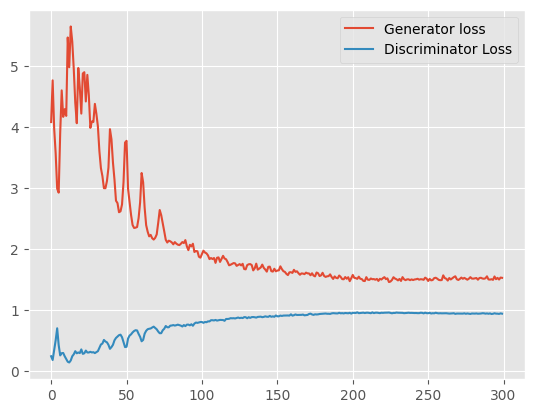

In [99]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g_list, label='Generator loss')
plt.plot(losses_d_list, label='Discriminator Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
